In [1]:
import os
import cv2
import json
import shutil
import random
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils import normalize_image

In [18]:
root_dir = '/data/jupiter/datasets/'
# root_dir = '/data/jupiter/avinash.raju/iq_2022_v7_anno'
dataset = 'halo_smudge_blur_and_dust_dataset_v1'
data_dir = os.path.join(root_dir, dataset, 'images')
df = pd.read_csv(os.path.join(root_dir, dataset, 'master_annotations.csv'), low_memory=False).sort_values(by='unique_id')
df.shape

(9126, 333)

In [4]:
# IQ result
iq_df = pd.read_csv(os.path.join(root_dir, 'iq.csv'))
print(iq_df.shape, iq_df[iq_df.iq != 'good'].shape)
iq_df.groupby('iq').count()

(3273, 179) (2558, 179)


,Unnamed: 0,annotation_categorical_0__cls,annotation_categorical_0__id,annotation_categorical_0_annotation_job,annotation_categorical_0_audit_mistakes,annotation_categorical_0_audit_requested,annotation_categorical_0_created_at,annotation_categorical_0_created_by,annotation_categorical_0_id,annotation_categorical_0_image,...,iq_features_total,iq_features_low,iq_features_mid,iq_features_high,iq_features_sharpness,iq_features_smudge,iq_features_smudge_reason,iq_process_time,binary_iq,binary_iq_ground_truth
iq,,,,,,,,,,,,,,,,,,,,,
bright,607,607,607,598,607,607,607,9,607,607,...,607,607,607,607,607,607,607,607,607,607
dark,447,447,447,447,447,447,447,0,447,447,...,447,447,447,447,447,447,447,447,447,447
good,715,715,715,715,715,715,715,0,715,715,...,715,715,715,715,715,715,715,715,715,715
smudge,1504,1504,1504,1504,1504,1504,1504,0,1504,1504,...,1504,1504,1504,1504,1504,1504,1504,1504,1504,1504


In [20]:
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
old_model = '9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_10_tr_br_dr_p2_v_p1_m_p1_u_dust_0624'
new_model = '9_2_unofficial_rev1_lying_down_sitting_25_ep_prod_weights_10_lo_5_tr_br_dr_p2_v_p1_m_p05_u_2_dust_0626'
# segmentation result
old_seg_csv = os.path.join(pred_root_dir, old_model, dataset, 'output.csv')
new_seg_csv = os.path.join(pred_root_dir, new_model, dataset, 'output.csv')
old_seg_df = pd.read_csv(old_seg_csv).sort_values(by='unique_id')
new_seg_df = pd.read_csv(new_seg_csv).sort_values(by='unique_id')
print(old_seg_df.shape, new_seg_df.shape)
print(old_seg_df[old_seg_df.result_state == 'false_positive'].shape, new_seg_df[new_seg_df.result_state == 'false_positive'].shape)

(9126, 15) (9126, 15)
(719, 15) (734, 15)


In [21]:
# dust detection result
old_dust_csv = os.path.join(pred_root_dir, old_model, dataset, 'dust_ratio.csv')
new_dust_csv = os.path.join(pred_root_dir, new_model, dataset, 'dust_ratio.csv')
old_dust_df = pd.read_csv(old_dust_csv).sort_values(by='unique_id')
new_dust_df = pd.read_csv(new_dust_csv).sort_values(by='unique_id')
print(old_dust_df.shape, new_dust_df.shape)

dust_thres = 0.05
print(df[old_dust_df.total_averaged_dust_conf > dust_thres].shape, df[new_dust_df.total_averaged_dust_conf > dust_thres].shape)

(9126, 7) (9126, 7)
(106, 333) (75, 333)


<ipython-input-21-3b74088131ac>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[old_dust_df.total_averaged_dust_conf > dust_thres].shape, df[new_dust_df.total_averaged_dust_conf > dust_thres].shape)


In [22]:
new_dust_df.head(2)

,unique_id,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio
1280,65fbc5048900f07805826450_T05_T07,65fbc5048900f07805826450,0.0,0.000242,0.0,0.000010,0.0
895,65fbc50956f7dd4eda9b0d52_T01_T03,65fbc50956f7dd4eda9b0d52,0.0,0.005869,0.0,0.006508,0.0


In [23]:
# combined results
print(df[(old_seg_df.result_state == 'false_positive') | (old_dust_df.total_averaged_dust_conf > dust_thres)].shape, df[(new_seg_df.result_state == 'false_positive') | (new_dust_df.total_averaged_dust_conf > dust_thres)].shape)
# print(df[(iq_df.iq != 'good') | (old_seg_df.result_state == 'false_positive') | (old_dust_df.total_averaged_dust_conf > dust_thres)].shape, df[(iq_df.iq != 'good') | (new_seg_df.result_state == 'false_positive') | (new_dust_df.total_averaged_dust_conf > dust_thres)].shape)

(825, 333) (809, 333)


<ipython-input-23-9db6be9d7655>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[(old_seg_df.result_state == 'false_positive') | (old_dust_df.total_averaged_dust_conf > dust_thres)].shape, df[(new_seg_df.result_state == 'false_positive') | (new_dust_df.total_averaged_dust_conf > dust_thres)].shape)


In [12]:
df.groupby('camera_location').size()

camera_location
T01    1389
T02    2331
T05     688
T06     903
T09     438
T10    1226
T13     649
T14    1502
dtype: int64

In [ ]:
df = df.merge(old_seg_df[['unique_id', 'result_state']], on='unique_id').merge(old_dust_df[['unique_id', 'total_averaged_dust_conf']], on='unique_id')

(724, 335)
660296524cdec5c215f30777_T02_T03 old dust pred: 0.0049284124


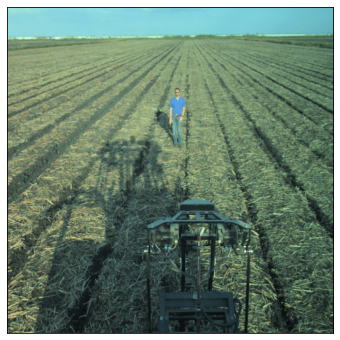

660291a86c95613c9707429c_T02_T03 old dust pred: 6.233115e-05


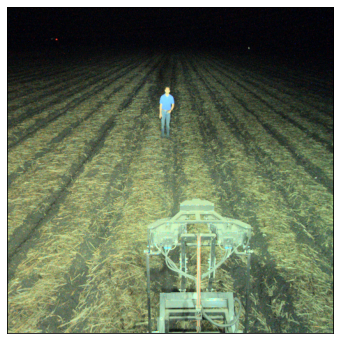

65fbe9e6a52812d3bde4c288_T10_T12 old dust pred: 0.00225277


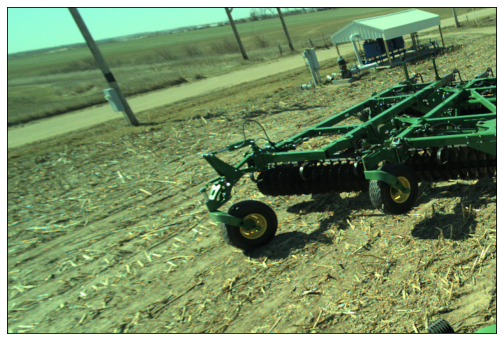

66029506e1e3500de515bf91_T02_T03 old dust pred: 0.009205387


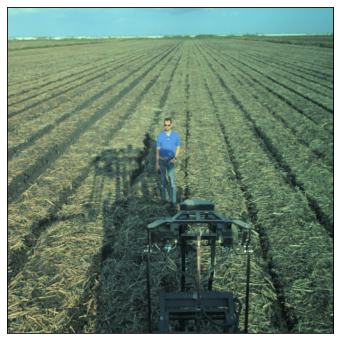

660297c39828381f45dc26c4_T06_T07 old dust pred: 0.0142980255


In [41]:
# # dust_diff = df[(old_dust_df.total_averaged_dust_conf > dust_thres) & (new_dust_df.total_averaged_dust_conf <= dust_thres)]
# sub_df1 = df[(old_dust_df.total_averaged_dust_conf > dust_thres) & (new_dust_df.total_averaged_dust_conf < dust_thres)]
# sub_df2 = df[(old_dust_df.total_averaged_dust_conf < dust_thres) & (new_dust_df.total_averaged_dust_conf > dust_thres)]
# dust_diff = pd.concat([sub_df1, sub_df2], ignore_index=True)
# print(sub_df1.shape, sub_df2.shape, dust_diff.shape)
# # print(dust_diff.groupby('operation_time').count())
# dust_diff = dust_diff[~dust_diff.unique_id.isin(iq_df[iq_df.iq == 'good'].unique_id)]
# print(dust_diff.shape)

# show sample images by selecting certain seg and dust pred results
dust_diff = df[(df.result_state == 'false_positive') | (df.total_averaged_dust_conf > 0.1)]
# dust_diff = df[(df.total_averaged_dust_conf > 0.1)]
print(dust_diff.shape)

sub_df = dust_diff.sample(5)
for i,sample_df in sub_df.iterrows():
    # unique_id = '614d0eb37585e5bf211d83dc'
    data_path = os.path.join(root_dir, dataset, sample_df.stereo_pipeline_npz_save_path)
    img = np.load(data_path)['left']
    img = normalize_image(img, sample_df.hdr_mode)

    # print(sample_df.unique_id, 'old dust pred:', old_dust_df[old_dust_df.unique_id == sample_df.unique_id].iloc[0].total_averaged_dust_conf, 'new dust pred:', new_dust_df[new_dust_df.unique_id == sample_df.unique_id].iloc[0].total_averaged_dust_conf)
    print(sample_df.unique_id, 'old dust pred:', sample_df.total_averaged_dust_conf)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()